# Challenge Set 13 NLP Unsupervised

Topic: NLP

Date: 02/24/2016

Name: Kenneth Myers

Worked with: NA

In [95]:
import numpy as np
from numpy import zeros
import pandas as pd
import pickle

from random import sample
from random import random
from collections import defaultdict

from sklearn.externals import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer


import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import mpld3

%matplotlib inline 


## Challenge 1

Cluster sentences with K-means. If you have your own Fletcher text data, get sentences out and cluster them. If not, cluster the tweets you gathered during the last challenge set. For each cluster, print out the sentences, try to see how close the sentences are. Try different K values and try to find a K value that makes the most sense (the sentences look like they do form a meaningful cluster).

How do you deal with retweets (if you're clustering tweets)?

### Note
I will be working with my own dataset.

In [2]:
with open('tableaucolors.pkl', 'rb') as file:
    tbl_colors = pickle.load(file)

In [35]:
full_data = pd.read_csv('full_anime_data_set.csv')

In [36]:
full_data.dropna(subset=['synopsis'], inplace=True)

In [37]:
synops = list(full_data['synopsis'])

### Preprocessing

In [6]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [7]:
stops = [
    "episode", "dvd", "special", "short", "movie", "included", "recap", "season", 
    "second", "film", "volume", "bundled", "tv", "aired", "version", "ova", 
    "tv", "animation", "animated", "releases", "based", "novel", "ova", "released",
    "manga", "edition", "featuring", "features", "created", "called",
    "main", "lot", "named", "feature", "anime", "adaptation", "releases",
    "series", "information", "original", "characters", "new", "story",
    "ovum", "character", "produced", "final", "meet", "scenes", "various", "plot",
    "video", "meeting", "people", "release", "end", "japanese", "japan", "young",
    "episodes", "include", "specials", "animate", "base", "game", "later", "contain",
    "set", "volumes", "bundle", "air", "different", "limit",
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"]

In [8]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text.replace("'", '')) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [lemmatizer.lemmatize(t, pos='v') for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text.replace("'", '')) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synops:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 564444 items in vocab_frame


### Bag of words

In [68]:
wordbag_vectorizer = CountVectorizer(analyzer = "word",   \
                                     tokenizer = None,    \
                                     preprocessor = None, \
                                     max_df = 0.2, \
                                     min_df = 0.01, \
                                     stop_words = stops,   \
                                     max_features = 5000)

In [69]:
bag_of_words = wordbag_vectorizer.fit_transform(synops)
bag_of_words = bag_of_words.toarray()

In [85]:
vocab_dict = wordbag_vectorizer.vocabulary_

    
terms = []
for k,_ in vocab_dict.items():
    terms.append(k)
    
terms = np.sort(np.array(terms))


In [92]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(bag_of_words)

clusters = km.labels_.tolist()

CPU times: user 11.7 s, sys: 298 ms, total: 12 s
Wall time: 8.3 s


In [93]:
full_data['clusters'] = clusters
full_data.set_index('clusters', inplace=True)
full_data.head()
cluster_names = defaultdict(str)

In [106]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in list(full_data.ix[i]['title'].values)[:30]:
        try:
            print(' %s,' % title, end='')
        except:
            pass
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'father', b'mother', b'day', b'girl', b'old', b'boy',

Cluster 0 titles: Prince of Tennis, Chuuka Ichiban!, Futakoi, Hunter x Hunter, Initial D First Stage, Initial D Third Stage, Ranma ½, Groove Adventure Rave, Grappler Baki (TV), Zettai Shounen, Futatsu no Spica, Magical Canan, Fate/stay night, Bannou Bunka Neko-Musume, Capeta, InuYasha: Toki wo Koeru Omoi, Kurau Phantom Memory, Kamui no Ken, Makai Toshi Shinjuku, Major S1, Koi Kaze, Patapata Hikousen no Bouken, Papa to Kiss in the Dark, Detective Conan Movie 02: The Fourteenth Target, Ginga Densetsu Weed, Zetsuai 1989, Taiyou no Ouji: Horus no Daibouken, The SoulTaker: Tamashii-gari, Pokemon: Kesshoutou no Teiou Entei, Windaria,

Cluster 1 words: b'schools', b'high', b'student', b'girls', b'clubs', b'day',

Cluster 1 titles: Eyeshield 21, School Rumble, Tenshi Kinryouku, D.C.: Da Capo, Cluster Edge, Full Metal Panic!, Full Metal Panic? Fumoffu, Gakuen Alice, Boys Be..., Green Green, Maria-sa

## Challenge 2

Draw the inertia curve over different k values. (The sklearn KMeans class has an inertia_ attribute.)

##### K means

In [90]:
inertias = []
cluster_range = list(range(1,18,1))
for cluster_size in cluster_range:
    temp_list = []
    for _ in range(3):
        temp_km = KMeans(n_clusters=cluster_size)
        temp_km.fit(tfidf_matrix)
        temp_list.append(temp_km.inertia_)
        
    inertias.append(np.mean(temp_list))

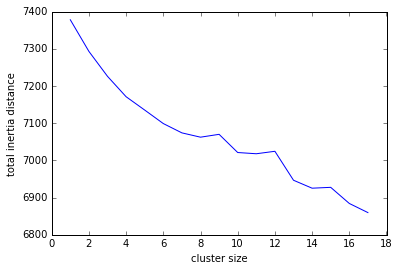

In [91]:
plt.plot(cluster_range, inertias)
plt.ylabel('total inertia distance')
plt.xlabel('cluster size')
plt.show()

## Challenge 3

Let's name the clusters 1

For each cluster, find the sentence closest to the centroid of the cluster.

(You can use [sklearn.metrics.pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) or [scipy.spatial.distance](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html) [check pdist, cdist, and euclidean distance] to find distances to the centroid). KMeans has a cluster_centers_ attribute.

This sentence (closest to centroid) is now the name of the cluster. For each cluster, print the representative sentence, and print 'N people expressed a similar statement', or something like that relevant to your dataset. (This is very close to what amazon used to do in the reviews section.)

Find the biggest 3 clusters, and print their representative sentences. (This is close to what amazon is doing now in the reviews section, except they choose the sentence from the most helpful review instead of closest to center.)

In [113]:
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    
    pw_dists = pairwise_distances(bag_of_words, order_centroids[i].reshape(1,-1))
    min_index = np.argmin(pw_dists)
    
    print('\nMost similar synopsis:')
    print(synops[min_index])
    
    print('\nThe number of series in this cluster is: ', len(full_data.ix[i]), '\n\n')

Cluster 0 words: b'father', b'mother', b'day', b'girl', b'old', b'boy',
Most similar synopsis:
GOSHO collection reveals the origin of the smash hit "Detective Conan." "GO" into his world, and we will "SHO" you SEVEN romantic and exciting stories created by GOSHO AOYAMA. WAIT FOR ME A genius inventor, who is still a high school student, has a girlfriend two years older than him. One day, he invents a time machine and attempts to go two years back into the past, to become the same age as her. However, it is she who ultimately uses the machine to travel through time! TEN PLANETS IN THE NIGHT SKY Meet Baby Conan! Yukiko Kudo is looking for her missing husband. The only clue to find him again is to decipher a mysterious message left for her. Their baby, Shinichi Kudo, one who later becomes the famous high school Detective Conan, will at this age already be offering some important hints for her. THE WANDERING RED BATTERFLY A handsome detective, Yusaku Kitakata, receives phone calls from a my

This is very interesting and kind of hilarious. The same series is appearing 4 times because it is actually a collection of short stories and the description covers each story (each story being very different).

## Challenge 4

Let's name the clusters 2

Calculate the tf-idf of each word in each cluster (think of all sentences of a cluster together as a document). Represent each cluster with the top 1, or top 2 or... to 5 tf-idf words. For each cluster, print the name (keywords) of the cluster, and "N statements" in the cluster (N is the size of the cluster)


In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.2, max_features=200000,
                                   min_df=0.01, stop_words=stops,
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(synops) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(8733, 424)


In [12]:
terms = tfidf_vectorizer.get_feature_names()

In [13]:
print(terms)

['ability', 'able', 'academy', 'accept', 'accident', 'act', 'action', 'actually', 'adventure', 'age', 'ago', 'alien', 'allow', 'ancient', 'appear', 'arm', 'army', 'arrive', 'art', 'ask', 'attack', 'attempt', 'attend', 'awaken', 'away', 'bad', 'band', 'battle', 'bear', 'beautiful', 'begin', 'believe', 'best', 'better', 'big', 'black', 'blue', 'body', 'book', 'box', 'boy', 'boys', 'break', 'bring', 'brother', 'build', 'captain', 'capture', 'care', 'case', 'cat', 'catch', 'cause', 'center', 'century', 'challenge', 'chance', 'change', 'child', 'childhood', 'childhood friend', 'children', 'choose', 'city', 'class', 'classmates', 'close', 'club', 'combat', 'come', 'comedy', 'company', 'complete', 'continue', 'control', 'country', 'course', 'create', 'creatures', 'crew', 'cute', 'dark', 'daughter', 'day', 'days', 'dead', 'deal', 'death', 'decide', 'deep', 'defeat', 'demon', 'demons', 'desire', 'despite', 'destroy', 'destruction', 'detective', 'determine', 'develop', 'die', 'disappear', 'disco

In [14]:
dist = 1 - cosine_similarity(tfidf_matrix)

##### K means

In [22]:
inertias = []
cluster_range = list(range(1,18,1))
for cluster_size in cluster_range:
    temp_list = []
    for _ in range(3):
        temp_km = KMeans(n_clusters=cluster_size)
        temp_km.fit(tfidf_matrix)
        temp_list.append(temp_km.inertia_)
        
    inertias.append(np.mean(temp_list))

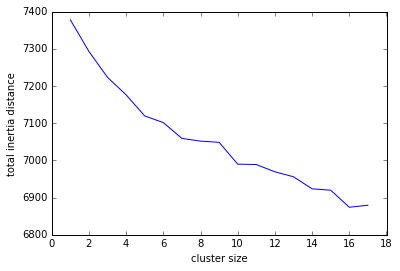

In [23]:
plt.plot(cluster_range, inertias)
plt.ylabel('total inertia distance')
plt.xlabel('cluster size')
plt.show()

Meaningless, need to use gap statistics

In [24]:
'''
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

def min_sparse(X):
    if len(X.data) == 0:
        return 0
    m = X.data.min()
    return m if X.getnnz() == X.size else min(m, 0)

def max_sparse(X):
    if len(X.data) == 0:
        return 0
    m = X.data.max()
    return m if X.getnnz() == X.size else max(m, 0)

def gap(data, refs=None, nrefs=10, ks=range(1,11)):
    """
    Compute the Gap statistic for an nxm dataset in data.
    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,
    or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.
    Give the list of k-values for which you want to compute the statistic in ks.
    """
    shape = data.shape
    if refs==None:
        tops = []
        bots = []
        for i in range(data.shape[1]):
            row = data.getcol(i)
            tops.append(max_sparse(row))
            bots.append(min_sparse(row))

        tops = np.array(tops)
        bots = np.array(bots)
        dists = scipy.matrix(scipy.diag(tops-bots))


        rands = scipy.random.random_sample(size=(shape[0],shape[1],20))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = scipy.zeros((len(ks),))
    for (i,k) in enumerate(ks):
        temp_km = KMeans(n_clusters=k)
        temp_km.fit_transform(data)
        kmc, kml = temp_km.cluster_centers_, temp_km.labels_
        disp = temp_km.inertia_

        refdisps = scipy.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            temp_km_2 = KMeans(n_clusters=k)
            temp_km_2.fit_transform(rands[:,:,j])
            refdisps[j] = scipy.log(temp_km_2.inertia_)
        print(k)
        print(scipy.mean(refdisps), scipy.log(disp))
        gaps[i] = scipy.mean(refdisps)-scipy.log(disp)
    return gaps
'''

'\nimport scipy\nimport scipy.cluster.vq\nimport scipy.spatial.distance\ndst = scipy.spatial.distance.euclidean\n\ndef min_sparse(X):\n    if len(X.data) == 0:\n        return 0\n    m = X.data.min()\n    return m if X.getnnz() == X.size else min(m, 0)\n\ndef max_sparse(X):\n    if len(X.data) == 0:\n        return 0\n    m = X.data.max()\n    return m if X.getnnz() == X.size else max(m, 0)\n\ndef gap(data, refs=None, nrefs=10, ks=range(1,11)):\n    """\n    Compute the Gap statistic for an nxm dataset in data.\n    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,\n    or state the number k of reference distributions in nrefs for automatic generation with a\n    uniformed distribution within the bounding box of data.\n    Give the list of k-values for which you want to compute the statistic in ks.\n    """\n    shape = data.shape\n    if refs==None:\n        tops = []\n        bots = []\n        for i in range(data.shape[1]):\n            row 

In [25]:
#gaps = gap(tfidf_matrix, ks=range(1,101,10))

Gap statistics was overly complicated and needs more time to explore

In [ ]:
num_clusters = 17

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = list(km.labels_)

In [ ]:
clusters[:10]

In [ ]:
full_data['clusters'] = clusters
full_data.set_index('clusters', inplace=True)
full_data.head()
cluster_names = defaultdict(str)

In [107]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in list(full_data.ix[i]['title'].values)[:30]:
        try:
            print(' %s,' % title, end='')
        except:
            pass
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'father', b'mother', b'day', b'girl', b'old', b'boy',

Cluster 0 titles: Prince of Tennis, Chuuka Ichiban!, Futakoi, Hunter x Hunter, Initial D First Stage, Initial D Third Stage, Ranma ½, Groove Adventure Rave, Grappler Baki (TV), Zettai Shounen, Futatsu no Spica, Magical Canan, Fate/stay night, Bannou Bunka Neko-Musume, Capeta, InuYasha: Toki wo Koeru Omoi, Kurau Phantom Memory, Kamui no Ken, Makai Toshi Shinjuku, Major S1, Koi Kaze, Patapata Hikousen no Bouken, Papa to Kiss in the Dark, Detective Conan Movie 02: The Fourteenth Target, Ginga Densetsu Weed, Zetsuai 1989, Taiyou no Ouji: Horus no Daibouken, The SoulTaker: Tamashii-gari, Pokemon: Kesshoutou no Teiou Entei, Windaria,

Cluster 1 words: b'schools', b'high', b'student', b'girls', b'clubs', b'day',

Cluster 1 titles: Eyeshield 21, School Rumble, Tenshi Kinryouku, D.C.: Da Capo, Cluster Edge, Full Metal Panic!, Full Metal Panic? Fumoffu, Gakuen Alice, Boys Be..., Green Green, Maria-sa

##### Multidimensional scaling/PCA

In [ ]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

from sklearn.decomposition import RandomizedPCA

In [ ]:
mds = MDS(n_components=2, dissimilarity="precomputed", n_init=2, max_iter=10, n_jobs=-2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

r_pca = RandomizedPCA(n_components=2)
pos = r_pca.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
titles = list(full_data.title)

In [ ]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 600);
      this.fig.toolbar.toolbar.attr("y", 0);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(15,10)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
i=0
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
                     label=cluster_names[name], mec='none', 
                     color=tbl_colors[i]
                    )
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    ax.legend(loc='upper left')
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    i+=1

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)